## **Tarea 1: Vocoder LPC**
### EL7022 Procesamiento de Voz en Telecomunicaciones
#### Integrantes : 
 - Vincko Fabres
 - Martín Moreno
 
#### Profesor : Néstor Becerra Y.
#### Profesor Auxiliar : Nicolas Grageda U.
#### Ayudantes : 
 - Catalina Murua F.
 - Jorge Wuth S.

# **Introducción**

La voz es generada por fuentes sonoras del tracto vocal, donde mediante el paso de aire se genera una excitación, provocando resonancias de cuerdas vocales las que dan paso a diferentes fonemas. Con esta motivación nacen los vocoders, los que corresponden a analizadores y sintetizadores de voz orientados a la telecomunicación, los cuales mediante el análisis de las frecuencias fundamentales y los respectivos formantes utilizadas en el habla representan la señal entregada para su posterior síntesis. La implementación de la técnica anteriormente mencionada disminuye el ancho de banda necesario para reconocer la voz, reduciendo la información a transmitir en comparación a la transmisión de información cruda.

Dado lo anterior, esta experiencia busca la implementación de un Vocoder LPC ,es decir, la implementación de un filtro IIR autoregresivo, para la codificación y decodificación de una señal correspondiente a la vocalización del fonema 'a' sostenido a lo largo del tiempo, este mecanismo de reconstrucción de la señal está pensado para tiempos muy reducidos, en donde se puede considerar una señal estacionaria, es decir, que tiene una potencia constante a lo largo del tiempo.  

# **Manipulación de la señal**


A lo largo de esta sección se verá tratamiento de la señal, correspondiente a un audio grabado y vocalizando una */a/* sostenida a lo largo de 5 segundos, esta señal está muestreada a una frecuencia de muestreo de 8kHz y ya se cortó anteriormente a los extremos, para que no haya ningun comportamiento extraño al principio ni al final de la señal.

En un primer lugar, se hace import a las librerías que se ocuparán a lo largo de este documento/código, correspondiente a numpy para las operaciones matemáticas, vectores y matrices; matplotlib para los gráficos múltiples; scipy para la la manipulación de un audio externo; google.colab para la subida de archivos; Ipython para escuchar audios dentro del archivo; y finalmente plotly.express para el gráfico interactivo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from google.colab import files
from scipy import signal
import IPython
import plotly.express as px

Código [3] corresponde a la subida del archivo, que se tendrá que cargar cada vez que se runnea todo el código. Se tiene que seleccionar el archivo "A.wav" adjuntado.

In [ ]:
from google.colab import drive
#drive.mount('/content/drive/')

files.upload()

Luego, se procede a leer el archivo subido, el cual viene como una lista, la primera componente corresponde al valor de la frecuencia de muestreo, mientras que *v* corresponde a las muestras del audio. Notar que debido a que el audio es de 5 s, habrán 40.000 muestras en este vector.

Finalmente, se normaliza y se procede a reporducir el audio.

In [ ]:
#a = read("/content/drive/MyDrive/EL7022/A.wav")
a = read("A.wav")
fs = a[0]
Ts = 1/fs
v = a[1]
time = len(v)/fs
t = np.arange(0, time, Ts)

v=v/max(v)
IPython.display.Audio(v, rate=fs)

A continuación se muestra el comportamiento de la señal en el dominio temporal, con un gráfico interactivo.

In [ ]:
fig = px.line(x=t, y=v)
fig.update_layout(
    title="Señal de voz original",
    xaxis_title="Tiempo [s]",
    yaxis_title="Amplitud")

fig.show()

  Para estimar T se observa en mayor detalle la señal en el tiempo, aumentando la resolución.

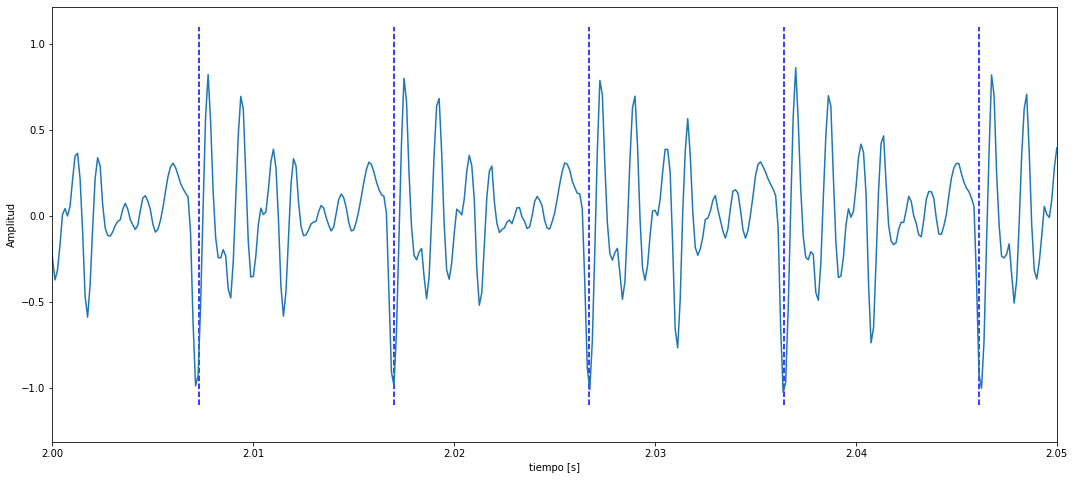

In [ ]:
T = 2.0170 - 2.0073
plt.plot(t, v)
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
com = 2.00
plt.xlim(com, com+0.05)
plt.vlines(x=2.0170, ymin= -1.1, ymax=1.1, color='b',ls='--')
plt.vlines(x=2.0073, ymin= -1.1, ymax=1.1, color='b',ls='--')
plt.vlines(x=2.0170+T, ymin= -1.1, ymax=1.1, color='b',ls='--')
plt.vlines(x=2.0170+2*T, ymin= -1.1, ymax=1.1, color='b',ls='--')
plt.vlines(x=2.0170+3*T, ymin= -1.1, ymax=1.1, color='b',ls='--')
plt.rcParams["figure.figsize"] = (18, 8)


plt.show()

Con la figura es posible observar el comportamiento periodico de la señal, con una frecuencia de 103[Hz] aproximadamente

In [ ]:
f0 = 1/T
print(f'T = {T} [s], f0 = {f0}[Hz]')

T = 0.009700000000000042 [s], f0 = 103.09278350515419[Hz]


Se procede a separar la señal en ventanas de 25 ms, lo que corresponde a la señal completa en 200 ventanas, con 200 muestras cada ventana.

In [ ]:
#Tomaremos ventanas de 25 ms = 0.025 s

tam_window = int(0.025 * fs)

windows = []

for i in np.arange(0, len(v), tam_window):
  windows = windows + [v[i:i+tam_window]]

# **Filtro LPC**

Para comenzar el procesamiento de la señal hacia un filtro LPC, en primer lugar se deberá definir la función correlación, la cual está dada por el código [9], el que replica la ecuación:

$R(i) = ∑_{n=i}^{N-1} x(n)x(n-i)$

Siendo *i* el número de la correlación, y *x* el vector al cual se desea sacar la correlación. En este caso el vector corresponde a cada una de las ventanas.

In [ ]:
# i = número
# x = ventana
def R(i, x):
  r=0
  N = len(x)
  i= abs(i)

  for n in range(i, N):
    r = r + x[n]*x[n-i]

  return r

Luego, ya teniendo la función de correlación, se procede a definir la función que obtiene los coeficientes LPC. Esta función recibe *win* que corresponde al vector que se desea obtener los coeficientes, y *p* que es la cantidad de coeficientes LPC. En primer lugar se sacan los valores de la correlación desde el 0 hasta el 10 (ambos inclusive), luego define la matriz y el vector de correlación, para luego despejar el vector A que contiene los coeficientes LPC. Esto se puede hacer sabiendo que se cumple la expresión *RA = r*.

In [ ]:
def coef_A(win, p):
  Rs = np.array([])
  for k in range(p+1):
    Rs=np.append(Rs, R(k, win))


  R_matriz = np.zeros((p, p)) 
  R_vector = np.zeros(p)

  for i in range(p):
    R_vector[i] = Rs[i+1]
    for k in range(p):
      R_matriz[i,k] = Rs[abs(i-k)]

  R_matriz_inv = np.linalg.inv(R_matriz)
  A = np.matmul(R_matriz_inv, R_vector)
  #para verificar
  #print(np.matmul(R_matriz, A))
  #print(R_vector)

  return A

Se calculan diez coeficientes LPC a la señal sin tratar. 

In [ ]:
p = 10    #cantidad de coef LPC

coef_LPC = []

for i in range(len(windows)):
  coef_LPC = coef_LPC + [coef_A(windows[i], p)]

print(coef_LPC[0])

[ 1.53535165 -0.91976862 -0.03461996 -0.01238947  0.0325182   0.11353281
 -0.08536599 -0.25678774  0.14477669  0.02921827]


Al utilizar la función de *Matlab LPC*, para los coeficientes correspondientes a la primera ventana:
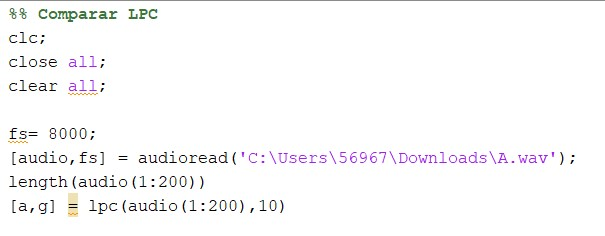

Se obtienen los siguientes valores:
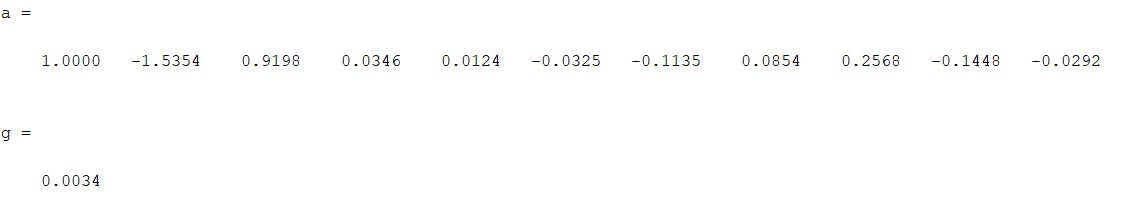



Con esto, se puede vizualizar que los valores son exactamentes los mismos, pero con el signo invertido.

A continuación, se procede a calcular la energía de cada ventana y el componente DC de cada ventana.

In [ ]:
Energia = np.array([])
for i in range(len(windows)):
  Energia = np.append(Energia,(sum((windows[i])**2)))
print(f'La energia promedio por ventana es : {np.mean(Energia)} +/- {np.std(Energia)} [J]')

componente_DC = np.array([])
for i in range(len(windows)):
  componente_DC = np.append(componente_DC,(np.mean(windows[i])))
print(f'El componente DC promedio por ventana es : {np.mean(componente_DC)} +/- {np.std(componente_DC)}')


La energia promedio por ventana es : 19.435858531033468 +/- 5.287001816392438 [J]
El componente DC promedio por ventana es : -1.519601572681495e-05 +/- 0.004186315370674271


Se le resta el componente DC a la señal, con la finalidad de quitarlo de esta para un mejor procesamiento.

In [ ]:
no_DC=windows-componente_DC

Se calculan 10 coeficientes LPC a la señal sin componente DC

In [ ]:
p = 10    #cantidad de coef LPC

coef_LPC_noDC = []

for i in range(len(windows)):
  coef_LPC_noDC = coef_LPC_noDC + [coef_A(no_DC[i], p)]

print(np.shape(coef_LPC_noDC))

(200, 10)


Luego, se crea el tren de impulsos que corresponde a la exitación del filtro, para luego separarlos por ventanas del mismo tamaño que las ventanas de la señal.

In [ ]:
impulsos = np.zeros(int(time*fs))
T0 = int(fs * T)

count = 0
while count<len(impulsos):
  if count%T0 ==0:
    impulsos[count] = 1
  count+=1

fig = px.line(x=t, y=impulsos)
fig.update_layout(
    title="Tren de impulsos",
    xaxis_title="Tiempo [s]",
    yaxis_title="Amplitud")
fig.show()

windows_imp = []

for i in np.arange(0, len(impulsos), tam_window):
  windows_imp = windows_imp + [v[i:i+tam_window]]

Posteriormente, se procede a pasar cada ventana del tren de impulsos creada anteriormente por el filtro, teniendo una ganancia constante igual a uno. Esto se hace teniendo en cuenta la ecuación para filtro IIR.

Luego se normaliza la señal y se guarda en este documente. Se grafica el resultado para interactuar con él y se reproduce el audio resultante.

In [ ]:
y = np.array([])

#Se filtra

for i in range(len(windows_imp)):
  x = windows_imp[i]
  a = coef_LPC[i]

  for n in range(len(x)):
    gain = 1
    y_n = gain * x[n]
    N = len(x)*i + n
    
    for L in range(len(a)):
      if (N-L-1) < 0:
        y_n = y_n + 0
      else:
        y_n = y_n + a[L]*y[N-L-1]
    y = np.append(y, y_n)

#Normalizar

y = y/max(y)
#Se guarda la señal
#write('/content/drive/MyDrive/EL7022/recreada_con_DC.wav', fs, y) 
write('recreada_con_DC.wav', fs, y) 

#Se plotea
fig = px.line(x=t, y=y)
fig.update_layout(
    title="Señal de voz recreada",
    xaxis_title="Tiempo [s]",
    yaxis_title="Amplitud")
fig.show()

IPython.display.Audio(y, rate=fs)

En seguida, se hace exactamente lo mismo que el punto anterior, pero en este caso con los coeficientes LPC de la señal sin componente DC, para así comparar más adelante.

In [ ]:
y_noDC = np.array([])

#Se filtra

for i in range(len(windows_imp)):
  x = windows_imp[i]
  a = coef_LPC_noDC[i]

  for n in range(len(x)):
    gain = 1
    y_n = gain * x[n]
    N = len(x)*i + n
    
    for L in range(len(a)):
      if (N-L-1) < 0:
        y_n = y_n + 0
      else:
        y_n = y_n + a[L]*y_noDC[N-L-1]
    y_noDC = np.append(y_noDC, y_n)

#Normalizar

y_noDC = y_noDC/max(y_noDC)
#Se guarda la señal
#write('/content/drive/MyDrive/EL7022/recreada.wav', fs, y) 
write('recreada_no_DC.wav', fs, y_noDC) 

#Se plotea
fig = px.line(x=t, y=y_noDC)
fig.update_layout(
    title="Señal de voz recreada",
    xaxis_title="Tiempo [s]",
    yaxis_title="Amplitud")
fig.show()

IPython.display.Audio(y_noDC, rate=fs)

# **Resultados**

Se proceden a graficar las tres señales con un zoom entre 2s y 2.05s. Corresponde a la señal original, la señal LPC con componente DC y la señal LPC sin componente DC.

Se puede apreciar que el único cambio entre la señal con DC y sin DC, es un desplazamiento en la amplitud, generando señales semejantes, esto se debe a que la componente DC de una señal no retiene información.

(2.0, 2.05)

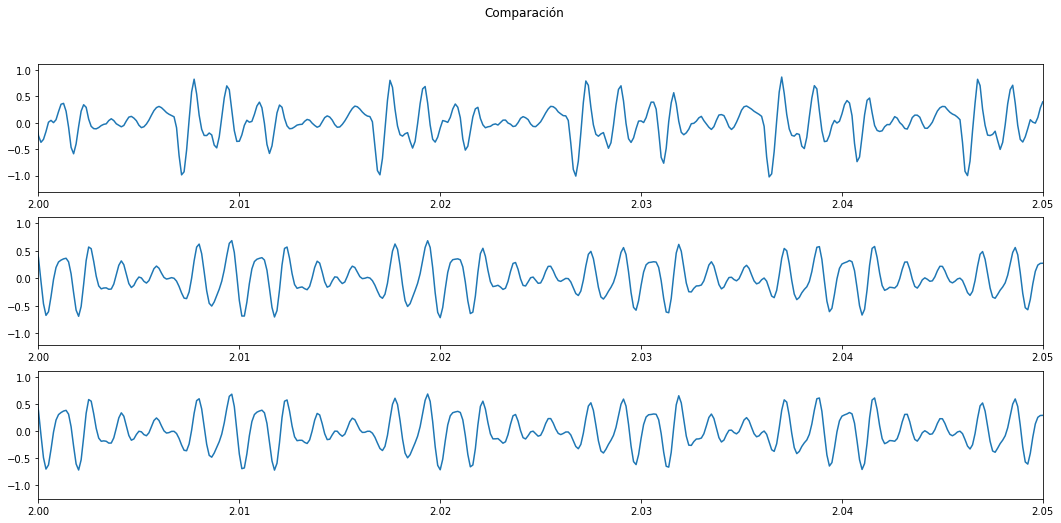

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(3)
fig.suptitle('Comparación')
ax1.plot(t, v)
ax1.set_xlim(2, 2.05)
ax2.plot(t, y)
ax2.set_xlim(2, 2.05)
ax3.plot(t, y_noDC)
ax3.set_xlim(2, 2.05)

In [ ]:
fourierTransform_original = np.fft.fft(v)/len(v)
fourierTransform_original = fourierTransform_original[range(int(len(v)/2))]
tpCount_o     = len(v)
values_o      = np.arange(int(tpCount_o/2))
timePeriod  = tpCount_o/fs
frequencies_o = values_o/timePeriod
#plt.plot(frequencies_o, abs(fourierTransform_original))

In [ ]:
fourierTransform_LPC = np.fft.fft(y)/len(y)
fourierTransform_LPC = fourierTransform_LPC[range(int(len(y)/2))]
tpCount_LPC     = len(y)
values_LPC      = np.arange(int(tpCount_LPC/2))
timePeriod_LPC  = tpCount_LPC/fs
frequencies_LPC = values_LPC/timePeriod_LPC

In [ ]:
fourierTransform_LPC_noDC = np.fft.fft(y_noDC)/len(y_noDC)
fourierTransform_LPC_noDC = fourierTransform_LPC_noDC[range(int(len(y)/2))]
tpCount_LPC_noDC     = len(y_noDC)
values_LPC_noDC      = np.arange(int(tpCount_LPC_noDC/2))
timePeriod_LPC_noDC  = tpCount_LPC_noDC/fs
frequencies_LPC_noDC = values_LPC_noDC/timePeriod_LPC_noDC

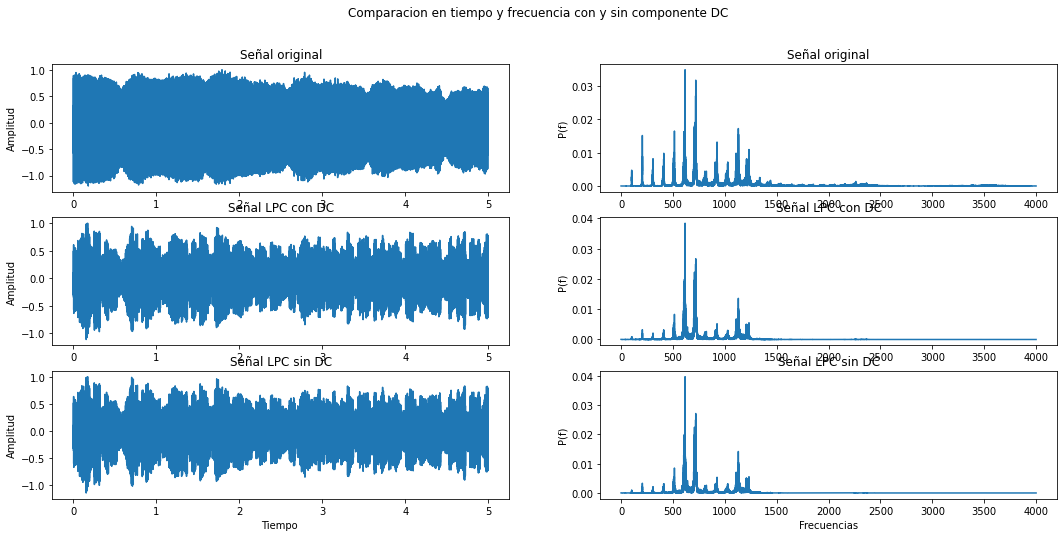

In [ ]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].plot(t, v)
axs[0, 0].set_title('Señal original')
axs[0, 0].set_ylabel('Amplitud')

axs[1, 0].plot(t, y)
axs[1, 0].set_title('Señal LPC con DC')
axs[1, 0].set_ylabel('Amplitud')
# axs[0, 0].set_xlabel('Tiempo')



axs[2, 0].plot(t, y_noDC)
axs[2, 0].set_title('Señal LPC sin DC')
axs[2, 0].set_ylabel('Amplitud')
axs[2, 0].set_xlabel('Tiempo ')


axs[0, 1].plot(frequencies_o, abs(fourierTransform_original))
axs[0, 1].set_title('Señal original')
axs[0, 1].set_ylabel('P(f)')

axs[1, 1].plot(frequencies_LPC, abs(fourierTransform_LPC))
axs[1, 1].set_title('Señal LPC con DC')
axs[1, 1].set_ylabel('P(f)')
# axs[0, 0].set_xlabel('Tiempo')


axs[2, 1].plot(frequencies_LPC_noDC, abs(fourierTransform_LPC_noDC))
axs[2, 1].set_title('Señal LPC sin DC')
axs[2, 1].set_ylabel('P(f)')
axs[2, 1].set_xlabel('Frecuencias')
fig.suptitle('Comparacion en tiempo y frecuencia con y sin componente DC')
plt.show()

En el siguiente gráfico se puede apreciar las diferencias en un plano general y temporal que tienen ambas señales a lo lago del tiempo. Se puede observar que la señal LPC tiene amplitudes más bajas que la original, esto puede deberse a que se calculó con una ganancia constante igual a uno, y no dependiendo de su energía.

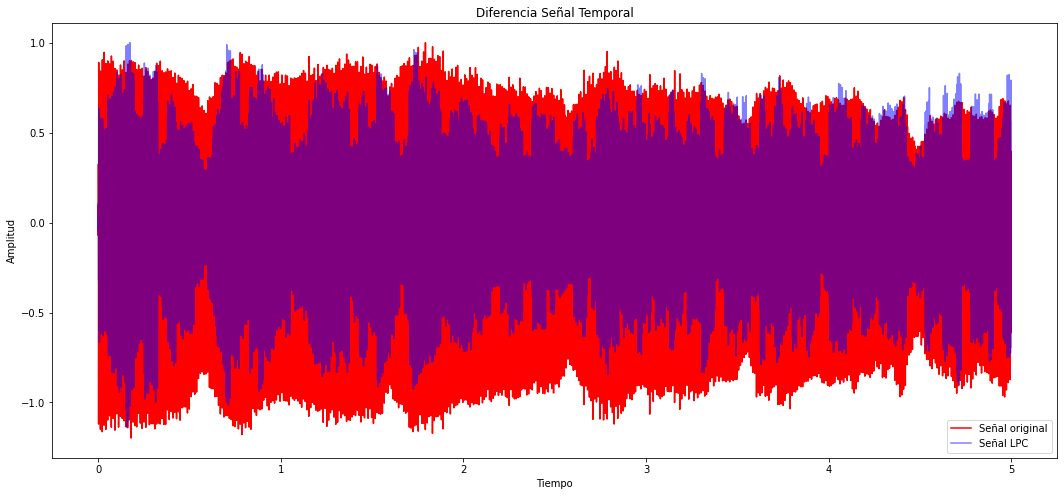

In [ ]:
plt.plot(t, v,color='r',label='Señal original')
plt.plot(t, y_noDC,color='b',alpha=0.5,label='Señal LPC')
plt.title('Diferencia Señal Temporal')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo')
plt.legend(loc='lower right')
plt.show()


Finalmente, se puede apreciar la diferencias que hay entre la señal orignal y la señal LPC en el dominio de la frecuencia, acá se puede visualizar una gran pérdida de información por parte de la señal creada, esto debido al limitado uso de coeficientes LPC (que fueron diez).

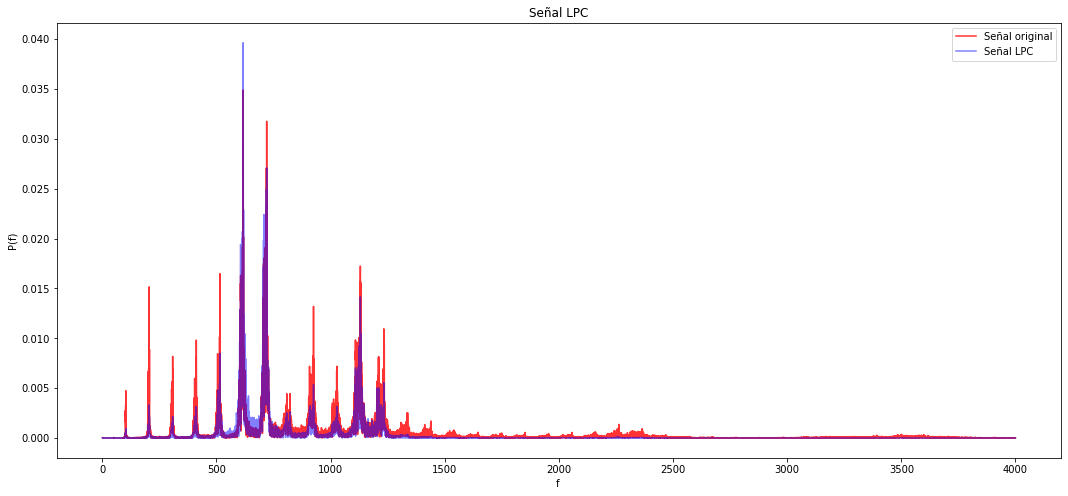

In [ ]:
plt.plot(frequencies_LPC, abs(fourierTransform_original),alpha=0.8,color='r',label='Señal original')
plt.plot(frequencies_LPC_noDC, abs(fourierTransform_LPC_noDC),alpha=0.5,color='b',label='Señal LPC')
plt.title('Señal LPC')
#plt.ylim(0,10**-3)
plt.ylabel('P(f)')
plt.xlabel('f ')
plt.legend(loc='upper right')
plt.show()


# **Conclusión**

A lo largo de esta tarea se trabajó sobre uno de los métodos auto-regresivos de la reconstrucción de una señal de voz, el método de análisis LPC, que tiene como objetivo tomar ventanas pequeñas de señales de voz, donde se consideran estacionarias, y obtener los coeficientes para un filtro, que serán los datos enviados. Visto lo anterior, en este caso se optó por tomar ventanas de 25 milisegundos a lo largo de una señal de 5 segundos, con una frecuencia de muestreo de 8kHz, donde está grabado un audio de voz que emana una letra /a/ constante en todo su tiempo. Se trabajó con 10 coeficientes LPC en cada ventana, obteniéndolos a partir del método Yule-Walker, y comparando el audio original y el audio reconstruido,donde se puede verificar que se entiende perfectamente el mensaje a transmitir de forma cualitativa, sin embargo, este contiene una breve pérdida de información, el cual se puede observar gráficamente con las imágenes mostrada en la sección de resultados.

En conclusión, se puede realizar una reconstrucción de una señal de voz que puede transmitir una cantidad considerable de información a partir de una cantidad menor de datos a enviar. Como lo es en este caso, donde cada ventana transmitió 10 datos de coeficientes LPC, un dato de ganancia y un dato que contiene la frecuencia de muestreo, en vez de transmitir una señal completa de 200 muestras. Esto hace que el tiempo y memoria para transmitir la señal sea menor, haciendo de este método más eficiente, ya que contrastando para este caso; por ventana de 200 muestras se tiene 1 Byte por muestra, es decir 200 Bytes, mientras que con LPC se necesitan sólo 12 valores o Bytes, obteniendo una señal que aún conserva la infromación reelvante para reconocer el mensaje.

Finalmente, este código se puede mejorar de diferentes maneras, por ejemplo implementando la ganancia por ventana, lo que haría que parte de la información no se perdiera. También, haciendo un código en donde *f0* se calcule automáticamente, ya que calcularlo a mano sólo funcionaría para señales relativamente constantes a lo largo del tiempo. Y para terminar, se podrían obtener más coeficientes LPC para una mejor reconstrucción de esta señal.

Para implementar este método en elocuciones cualesquiera, donde la señal no posee periodicidad constante, dados los fonemas utilizados, es posible detectar *f0* mediante autocorrelaciones, buscando el segundo mayor valor, el que correspondería a los valores correspondientes de un posible peak a otro.
